In [1]:
import numpy as np
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
#from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
country_to_predict="Libya"

**ARIMA**


In [3]:
df=pd.read_excel('test_arima.xlsx')
df['Year']=pd.to_datetime(df.Year, format="%Y")
df=df[(df['Country']==country_to_predict)]
df.index.freq = 'YS'
df.head()

,Year,Value,Country
196,1970-01-01,56.052,Libya
197,1971-01-01,57.046,Libya
198,1972-01-01,57.995,Libya
199,1973-01-01,58.902,Libya
200,1974-01-01,59.770,Libya


In [4]:
del df["Country"]

In [5]:
df['Year']=pd.to_datetime(df['Year'], format="%Y")
df=df.set_index(['Year'])
df.head()
df.index.freq = 'YS'

In [6]:
train_df = df[:len(df)-6]
test_df = df[len(df)-6:]

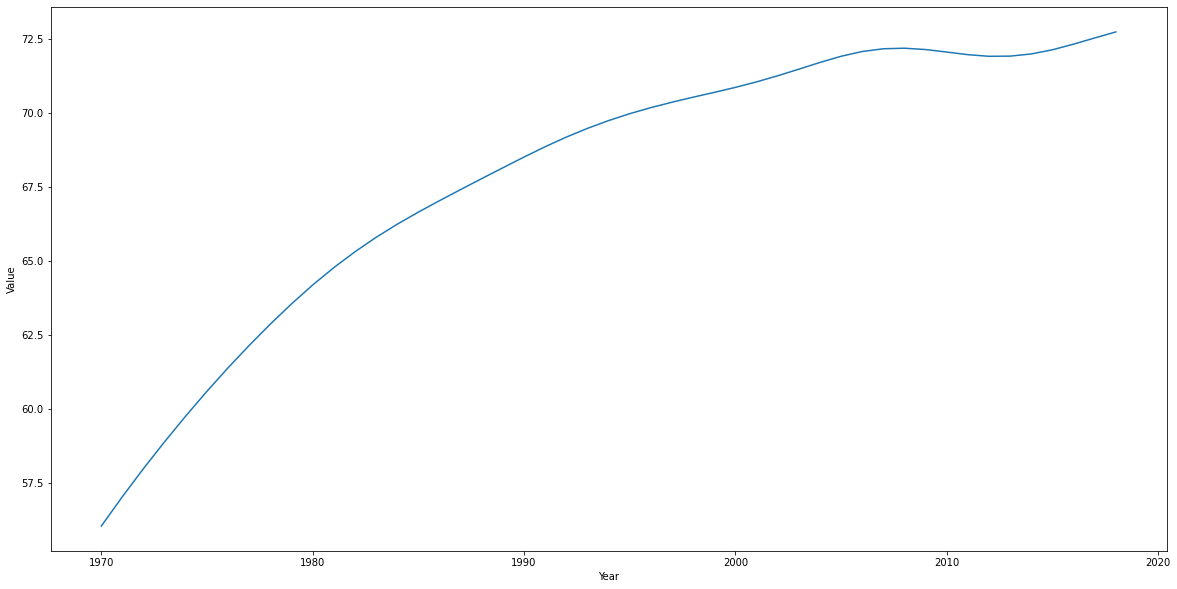

In [7]:
plt.figure(figsize=(20,10))
plt.xlabel("Year")
plt.ylabel("Value")
plt.plot(df)

In [8]:
rolmean=train_df.rolling(window=6).mean()
rolstd=train_df.rolling(window=6).std()
print(rolmean.head(15))
print(rolstd.head(15))

                Value
Year                 
1970-01-01        NaN
1971-01-01        NaN
1972-01-01        NaN
1973-01-01        NaN
1974-01-01        NaN
1975-01-01  58.394167
1976-01-01  59.284333
1977-01-01  60.135000
1978-01-01  60.947333
1979-01-01  61.721667
1980-01-01  62.457500
1981-01-01  63.152667
1982-01-01  63.804833
1983-01-01  64.412000
1984-01-01  64.973000
               Value
Year                
1970-01-01       NaN
1971-01-01       NaN
1972-01-01       NaN
1973-01-01       NaN
1974-01-01       NaN
1975-01-01  1.701714
1976-01-01  1.626777
1977-01-01  1.555129
1978-01-01  1.485124
1979-01-01  1.414956
1980-01-01  1.343190
1981-01-01  1.266747
1982-01-01  1.184207
1983-01-01  1.096736
1984-01-01  1.006807


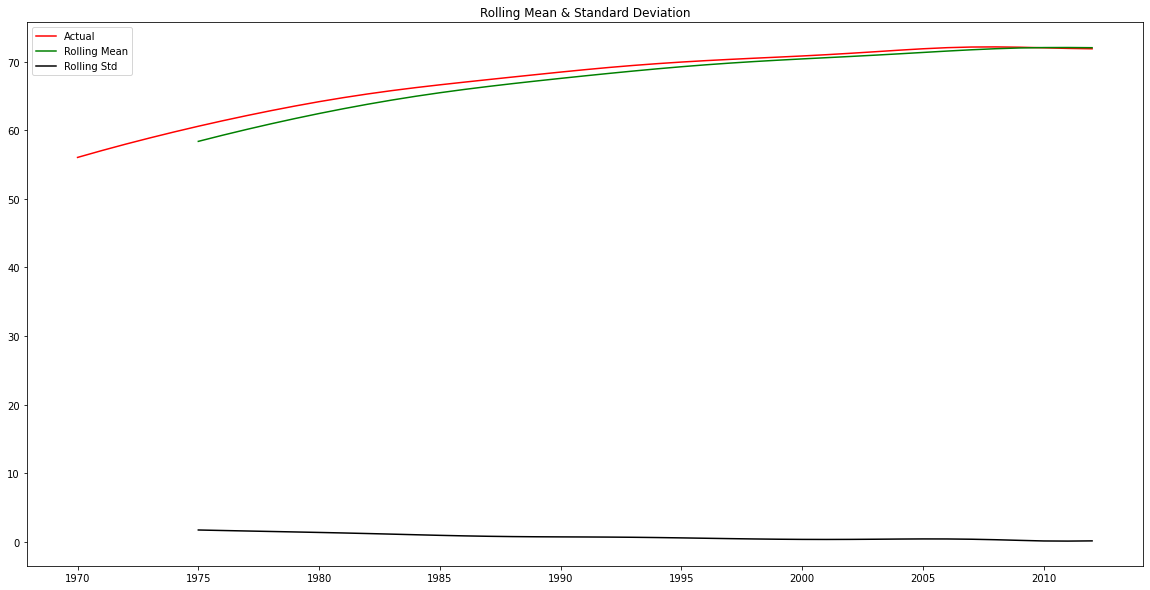

In [9]:
plt.figure(figsize=(20,10))
actual=plt.plot(train_df, color='red', label='Actual')
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [10]:
from statsmodels.tsa.stattools import adfuller
print('Dickey-Fuller Test: ')
dftest=adfuller(train_df['Value'], autolag='AIC')
dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Dickey-Fuller Test: 
Test Statistic          -2.983424
p-value                  0.036472
Lags Used                3.000000
No. of Obs              39.000000
Critical Value (1%)     -3.610400
Critical Value (5%)     -2.939109
Critical Value (10%)    -2.608063
dtype: float64


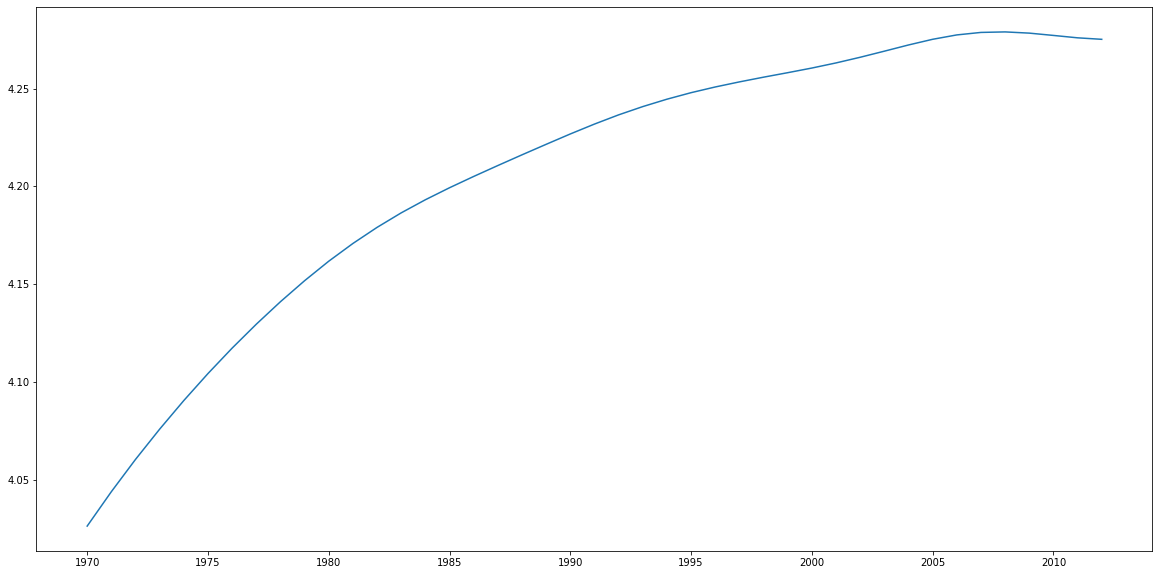

In [11]:
plt.figure(figsize=(20,10))
df_log=np.log(train_df)
plt.plot(df_log)

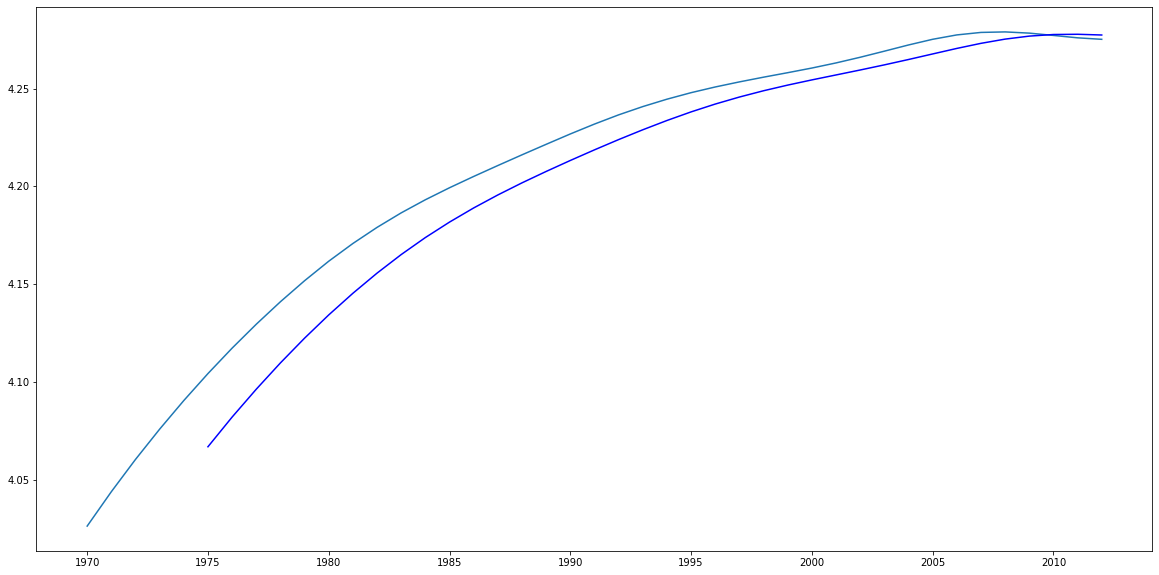

In [12]:
plt.figure(figsize=(20,10))
MAvg=df_log.rolling(window=6).mean()
MStd=df_log.rolling(window=6).std()
plt.plot(df_log)
plt.plot(MAvg, color='blue')

In [13]:
df_log_diff=df_log-MAvg
df_log_diff.head(12)

,Value
Year,
1970-01-01,NaN
1971-01-01,NaN
1972-01-01,NaN
1973-01-01,NaN
1974-01-01,NaN
1975-01-01,0.037433
1976-01-01,0.035265
1977-01-01,0.033238
1978-01-01,0.031291


In [14]:
df_log_diff=df_log_diff.dropna()
df_log_diff.head()

,Value
Year,
1975-01-01,0.037433
1976-01-01,0.035265
1977-01-01,0.033238
1978-01-01,0.031291
1979-01-01,0.029380


In [15]:
def stationarity(timeseries):
    
    rolmean=timeseries.rolling(window=6).mean()
    rolstd=timeseries.rolling(window=6).std()
    
    plt.figure(figsize=(20,10))
    actual=plt.plot(timeseries, color='red', label='Actual')
    mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
    std_6=plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Dickey-Fuller Test: ')
    dftest=adfuller(timeseries['Value'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

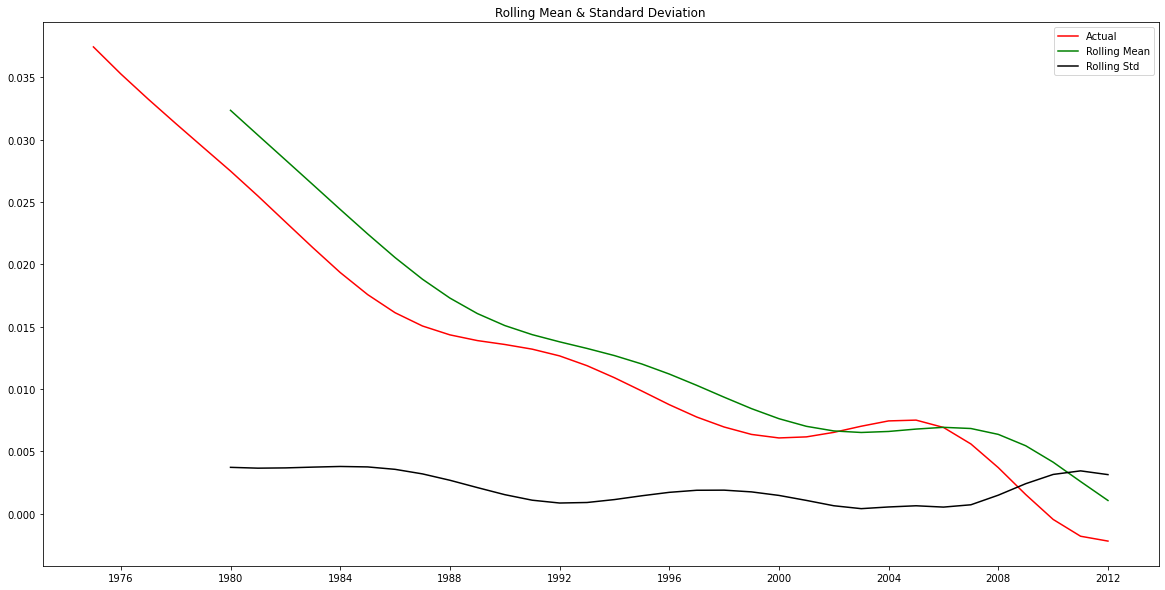

Dickey-Fuller Test: 
Test Statistic          -3.469082
p-value                  0.008818
Lags Used                3.000000
No. of Obs              34.000000
Critical Value (1%)     -3.639224
Critical Value (5%)     -2.951230
Critical Value (10%)    -2.614447
dtype: float64


In [16]:
stationarity(df_log_diff)

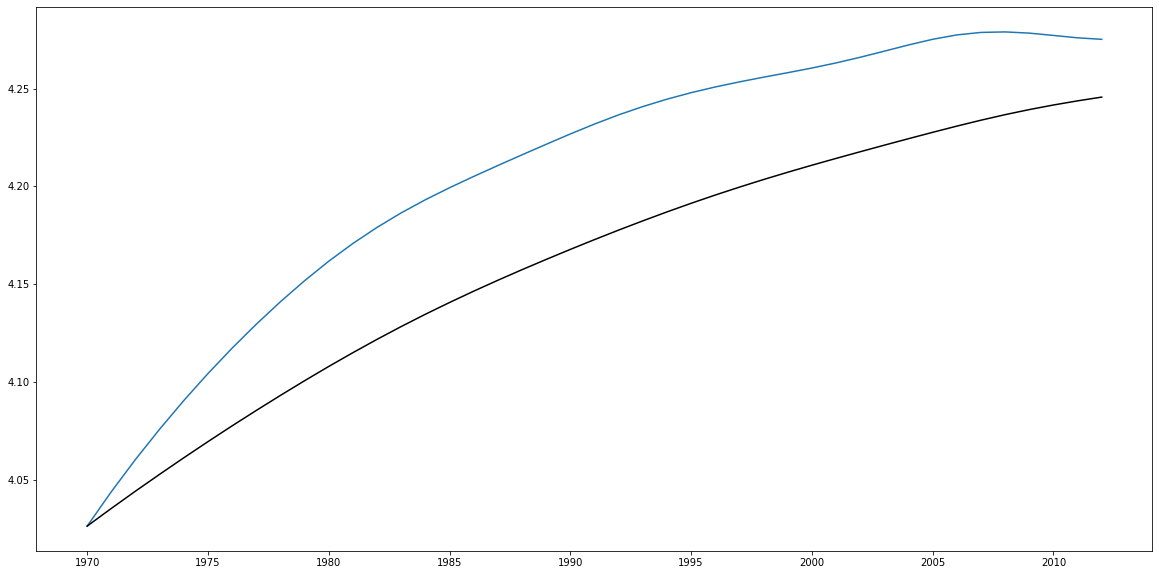

In [17]:
plt.figure(figsize=(20,10))
exp_df=df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(df_log)
plt.plot(exp_df, color='black')

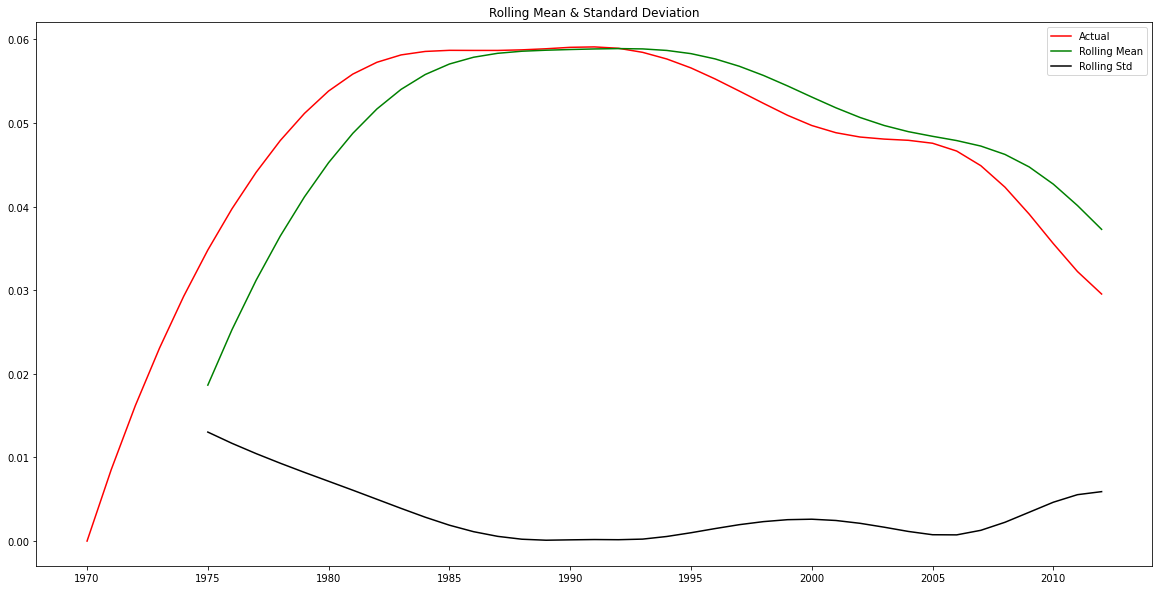

Dickey-Fuller Test: 
Test Statistic           0.356243
p-value                  0.979783
Lags Used                9.000000
No. of Obs              33.000000
Critical Value (1%)     -3.646135
Critical Value (5%)     -2.954127
Critical Value (10%)    -2.615968
dtype: float64


In [18]:
exp_df_diff=df_log-exp_df
stationarity(exp_df_diff)

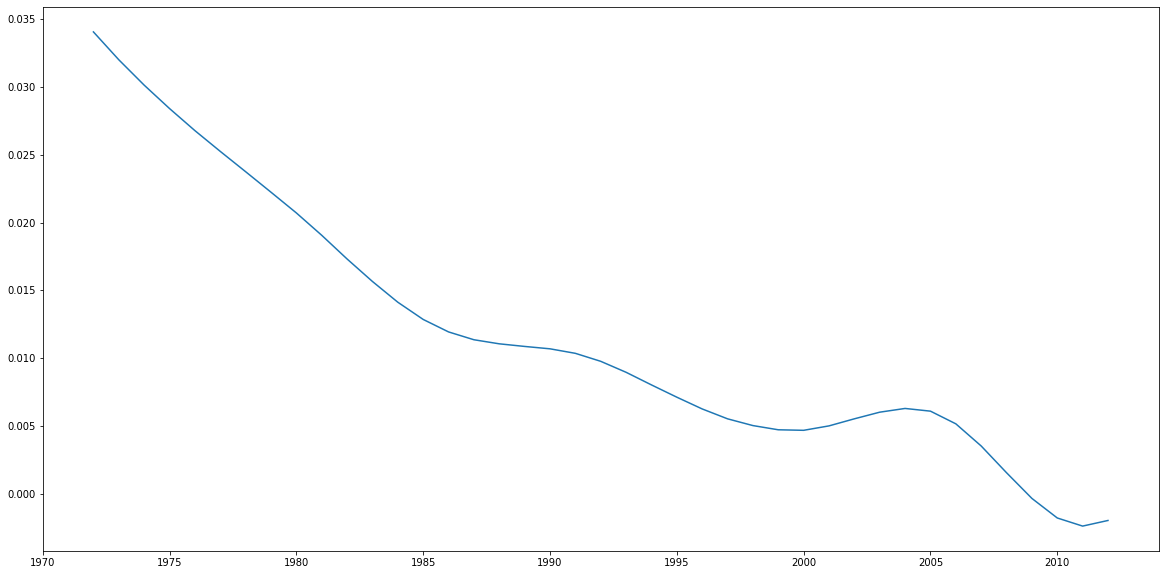

In [19]:
plt.figure(figsize=(20,10))
df_shift=df_log-df_log.shift(2)
plt.plot(df_shift)

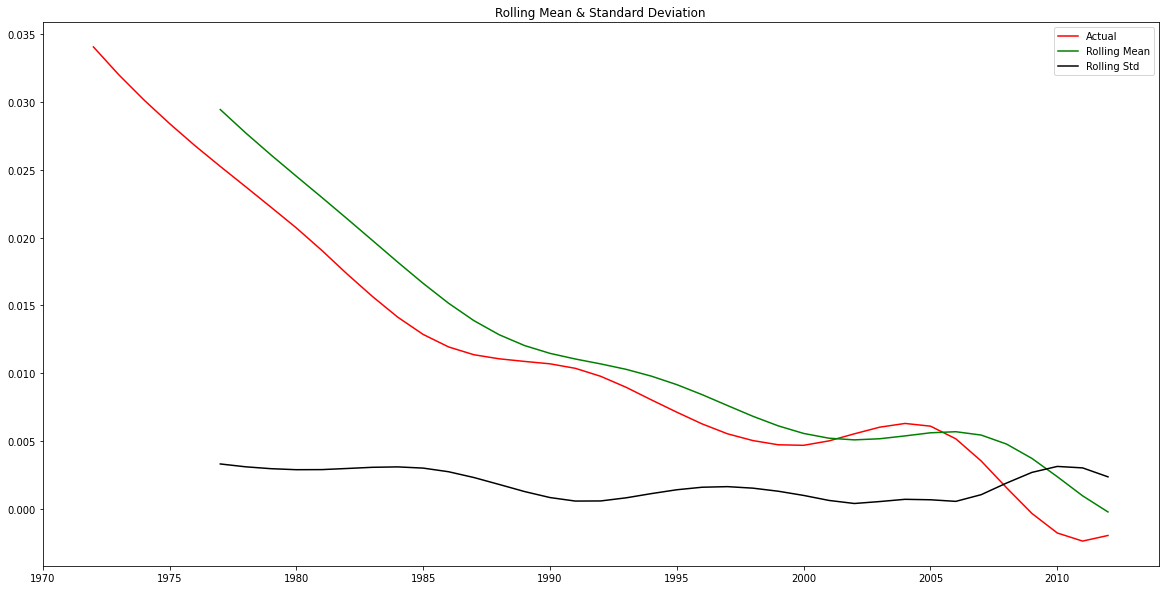

Dickey-Fuller Test: 
Test Statistic          -0.685367
p-value                  0.850504
Lags Used                9.000000
No. of Obs              31.000000
Critical Value (1%)     -3.661429
Critical Value (5%)     -2.960525
Critical Value (10%)    -2.619319
dtype: float64


In [20]:
df_shift=df_shift.dropna()
stationarity(df_shift)

Text(0.5, 1.0, 'Partial Autocorrelation Function')

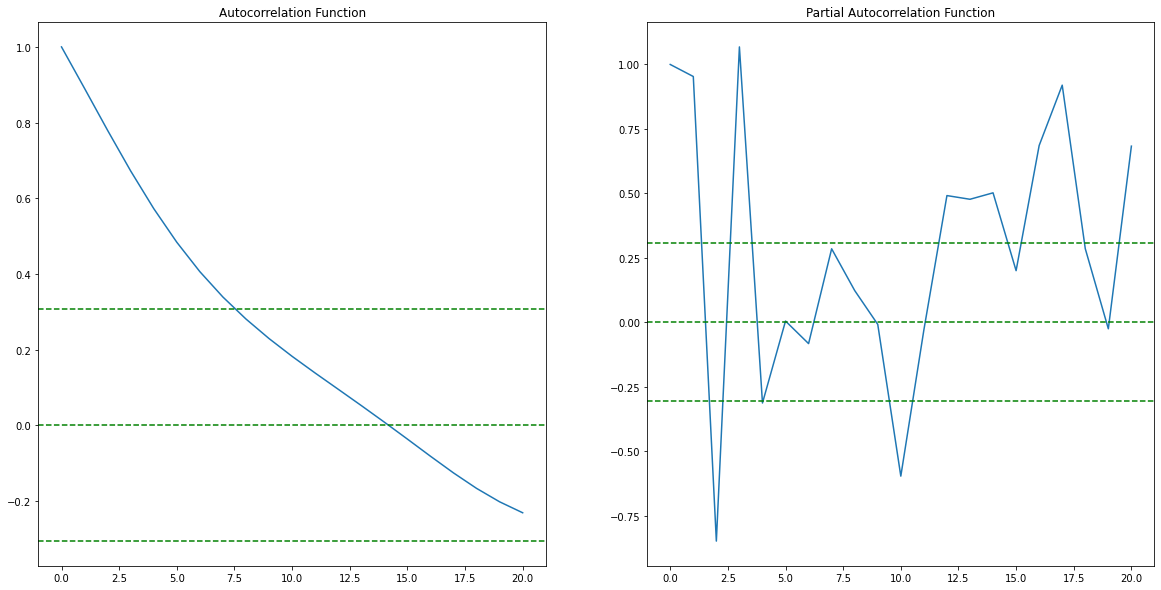

In [21]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf=acf(df_log_diff, nlags=20)
lag_pacf=pacf(df_log_diff, nlags=20, method='ols')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.title('Partial Autocorrelation Function')

plotting ARIMA model


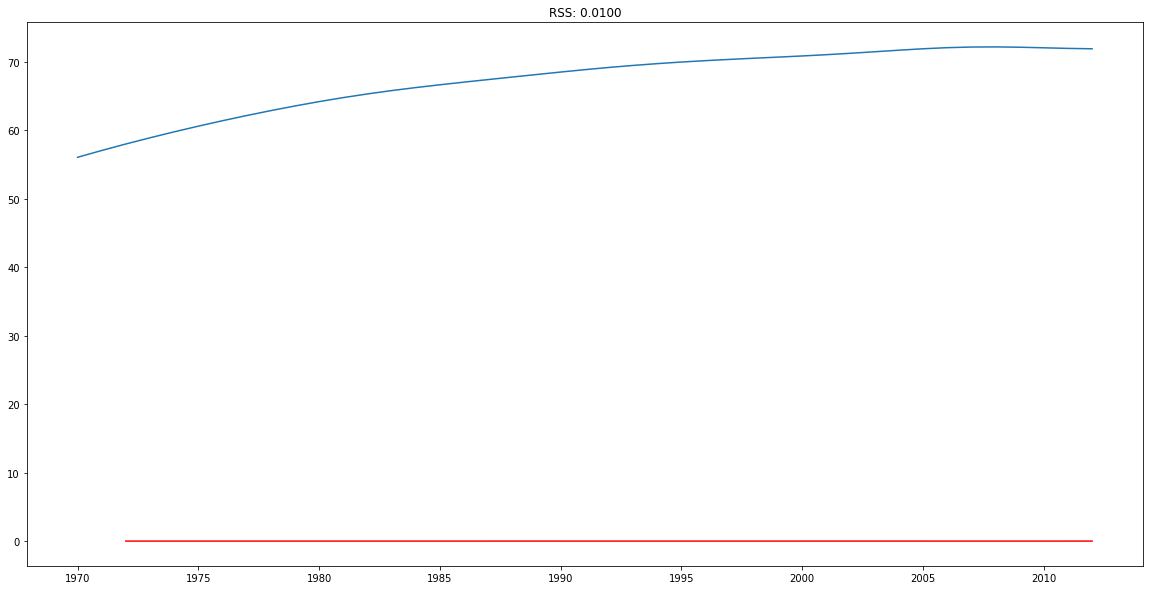

In [22]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize=(20,10))
model=ARIMA(df_log, order=(3,2,0))
results=model.fit(disp=-1)
plt.plot(train_df)
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results.fittedvalues-df_shift['Value'])**2))
print('plotting ARIMA model')

In [23]:
predictions=pd.Series(results.fittedvalues, copy=True)
print(predictions.head())

Year
1972-01-01   -0.000397
1973-01-01   -0.001026
1974-01-01   -0.000802
1975-01-01   -0.000768
1976-01-01   -0.000766
Freq: AS-JAN, dtype: float64


In [24]:
predictions_cum_sum=predictions.cumsum()
print(predictions_cum_sum.head())

Year
1972-01-01   -0.000397
1973-01-01   -0.001423
1974-01-01   -0.002226
1975-01-01   -0.002994
1976-01-01   -0.003761
Freq: AS-JAN, dtype: float64


In [25]:
predictions_log=pd.Series(df_log['Value'].iloc[0], index=df_log.index)
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
#predictions_log.head()

In [26]:
arima_pred = results.predict(start = len(train_df), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred=np.exp(arima_pred)
test_df['ARIMA_Predictions'] = arima_pred
#arima_pred


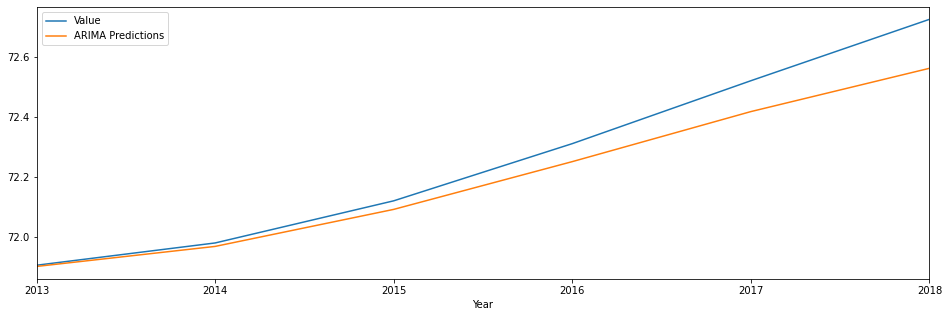

In [27]:
test_df['Value'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [28]:
arima_rmse_error = rmse(test_df['Value'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 0.006919115012462193
RMSE Error: 0.08318121790682192
Mean: 67.90228571428572


In [29]:
output=results.forecast(13)
output1=np.exp(output[0])
output1
outputs = pd.DataFrame(output1[-7:])
outputs.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
outputs["Country"]=country_to_predict
outputs

,0,Country
2019,72.656311,Libya
2020,72.683445,Libya
2021,72.633274,Libya
2022,72.506143,Libya
2023,72.310627,Libya
2024,72.060782,Libya
2025,71.772884,Libya


In [30]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_arima.xlsx')
writer = pandas.ExcelWriter('test_arima.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    outputs.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

In [31]:
test_df

,Value,ARIMA_Predictions
Year,,
2013-01-01,71.907,71.902947
2014-01-01,71.981,71.969526
2015-01-01,72.121,72.092529
2016-01-01,72.311,72.251227
2017-01-01,72.520,72.417461
2018-01-01,72.724,72.561308


**LSTM**

In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [33]:
df=pd.read_excel('test_lstm.xlsx')
df['Year']=pd.to_datetime(df.Year, format="%Y")
df=df[(df['Country']==country_to_predict)]
del df["Country"]
df['Year']=pd.to_datetime(df['Year'], format="%Y")
df=df.set_index(['Year'])
df.index.freq = 'YS'
train_df_lstm = df[:len(df)-6]
test_df_lstm = df[len(df)-6:]
df.tail()

,Value
Year,
2014-01-01,71.981
2015-01-01,72.121
2016-01-01,72.311
2017-01-01,72.520
2018-01-01,72.724


In [34]:
scaler.fit(train_df)
scaled_train_data = scaler.transform(train_df_lstm)
scaled_test_data = scaler.transform(test_df_lstm)

In [35]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 1
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [36]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(256, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               264192    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


In [37]:
lstm_model.fit_generator(generator,epochs=20)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
42/42 [==============================] - 0s 3ms/step - loss: 0.4268
Epoch 2/20
42/42 [==============================] - 0s 3ms/step - loss: 0.1717
Epoch 3/20
42/42 [==============================] - 0s 3ms/step - loss: 0.0275
Epoch 4/20
42/42 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 5/20
42/42 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 6/20
42/42 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 7/20
42/42 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 8/20
42/42 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 9/20
42/42 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 10/20
42/42 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 11/20
42/42 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 12/20
42/42 [==============================] - 

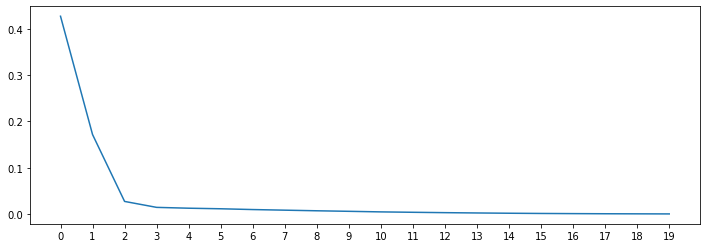

In [38]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [39]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_df)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [40]:
lstm_predictions_scaled

[array([0.98680955], dtype=float32),
 array([0.9905819], dtype=float32),
 array([0.99438834], dtype=float32),
 array([0.9982337], dtype=float32),
 array([1.0021228], dtype=float32),
 array([1.0060607], dtype=float32)]

In [41]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [42]:
lstm_predictions

array([[71.96134359],
       [72.02216187],
       [72.08352885],
       [72.14552332],
       [72.20822313],
       [72.27171092]])

In [43]:
test_df['LSTM_Predictions'] = lstm_predictions

In [44]:
test_df

,Value,ARIMA_Predictions,LSTM_Predictions
Year,,,
2013-01-01,71.907,71.902947,71.961344
2014-01-01,71.981,71.969526,72.022162
2015-01-01,72.121,72.092529,72.083529
2016-01-01,72.311,72.251227,72.145523
2017-01-01,72.520,72.417461,72.208223
2018-01-01,72.724,72.561308,72.271711


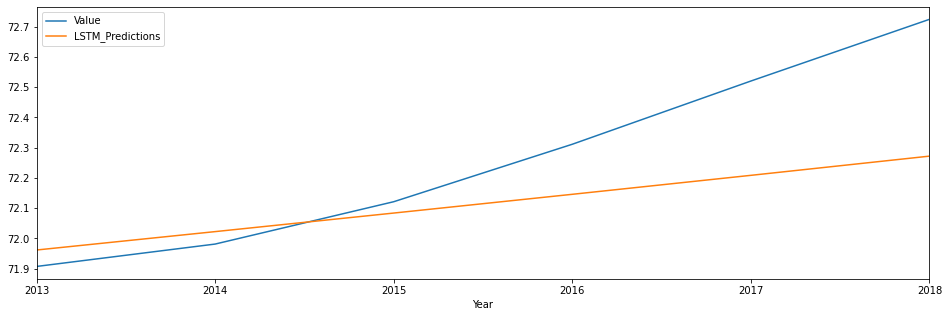

In [45]:
test_df['Value'].plot(figsize = (16,5), legend=True)
test_df['LSTM_Predictions'].plot(legend = True);

In [46]:
lstm_rmse_error = rmse(test_df['Value'], test_df["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 0.05586739496137379
RMSE Error: 0.2363628459834028
Mean: 67.90228571428572


In [47]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_df)+6):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [48]:
lstm_predictions_scaled

[array([0.98680955], dtype=float32),
 array([0.9905819], dtype=float32),
 array([0.99438834], dtype=float32),
 array([0.9982337], dtype=float32),
 array([1.0021228], dtype=float32),
 array([1.0060607], dtype=float32),
 array([1.0100532], dtype=float32),
 array([1.0141057], dtype=float32),
 array([1.0182242], dtype=float32),
 array([1.0224152], dtype=float32),
 array([1.026685], dtype=float32),
 array([1.0310408], dtype=float32)]

In [49]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [50]:
lstm_predictions

array([[71.96134359],
       [72.02216187],
       [72.08352885],
       [72.14552332],
       [72.20822313],
       [72.27171092],
       [72.33607701],
       [72.40141173],
       [72.46781119],
       [72.53537723],
       [72.60421556],
       [72.67443958]])

In [51]:
output2=lstm_predictions
outputs2 = pd.DataFrame(lstm_predictions[-7:])
outputs2.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
outputs2["Country"]=country_to_predict
outputs2

,0,Country
2019,72.271711,Libya
2020,72.336077,Libya
2021,72.401412,Libya
2022,72.467811,Libya
2023,72.535377,Libya
2024,72.604216,Libya
2025,72.674440,Libya


In [52]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_lstm.xlsx')
writer = pandas.ExcelWriter('test_lstm.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    outputs2.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

**Prophet**

In [53]:
df = pd.read_excel('test_prophet.xlsx')
df=df[(df['Country']==country_to_predict)]
del df["Country"]
df.head()
df_pr = df.copy()
#df = df.reset_index()
df_pr.columns = ['ds','y']
df_pr.tail()


,ds,y
240,2014,71.981
241,2015,72.121
242,2016,72.311
243,2017,72.520
244,2018,72.724


In [54]:
df_pr['ds'] = pd.to_datetime(df_pr['ds'],format="%Y")
df_pr.tail()

,ds,y
240,2014-01-01,71.981
241,2015-01-01,72.121
242,2016-01-01,72.311
243,2017-01-01,72.520
244,2018-01-01,72.724


In [55]:
train_data_pr = df_pr.iloc[:len(df)-6]
test_data_pr = df_pr.iloc[len(df)-6:]

In [56]:
from fbprophet import Prophet

In [57]:
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=6,freq='YS')
prophet_pred = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [58]:
prophet_pred.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
44,2014-01-01,20.545495,72.127620,72.413886,20.476589,20.621673,51.718340,51.718340,51.718340,51.718340,51.718340,51.718340,0.0,0.0,0.0,72.263836
45,2015-01-01,20.597989,72.114203,72.505816,20.452695,20.741412,51.708692,51.708692,51.708692,51.708692,51.708692,51.708692,0.0,0.0,0.0,72.306681
46,2016-01-01,20.650482,72.102730,72.652775,20.399061,20.888418,51.725684,51.725684,51.725684,51.725684,51.725684,51.725684,0.0,0.0,0.0,72.376166
47,2017-01-01,20.703119,72.071473,72.837587,20.355654,21.060531,51.753214,51.753214,51.753214,51.753214,51.753214,51.753214,0.0,0.0,0.0,72.456333
48,2018-01-01,20.755612,72.006784,72.944599,20.282144,21.238817,51.718340,51.718340,51.718340,51.718340,51.718340,51.718340,0.0,0.0,0.0,72.473953


In [59]:
prophet_pred = pd.DataFrame({"Year" : prophet_pred[-6:]['ds'], "Pred" : prophet_pred[-6:]["yhat"]})

In [60]:
prophet_pred = prophet_pred.set_index("Year")

In [61]:
prophet_pred.index.freq = "YS"

In [62]:
prophet_pred

,Pred
Year,
2013-01-01,72.246216
2014-01-01,72.263836
2015-01-01,72.306681
2016-01-01,72.376166
2017-01-01,72.456333
2018-01-01,72.473953


In [63]:
test_df["Prophet_Predictions"] = prophet_pred['Pred'].values
test_df

,Value,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions
Year,,,,
2013-01-01,71.907,71.902947,71.961344,72.246216
2014-01-01,71.981,71.969526,72.022162,72.263836
2015-01-01,72.121,72.092529,72.083529,72.306681
2016-01-01,72.311,72.251227,72.145523,72.376166
2017-01-01,72.520,72.417461,72.208223,72.456333
2018-01-01,72.724,72.561308,72.271711,72.473953


In [64]:
import seaborn as sns

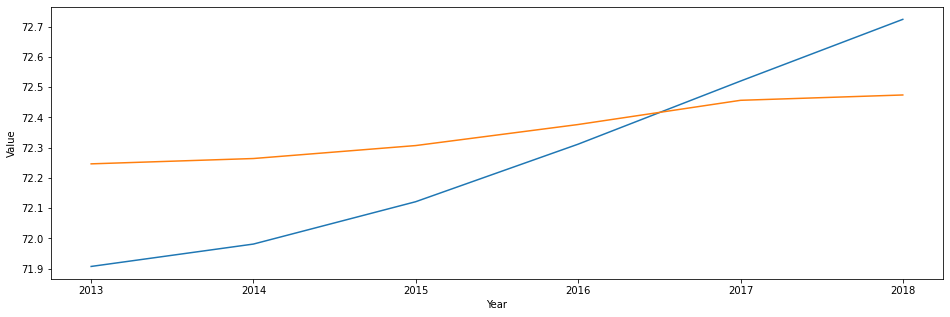

In [65]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_df.index, y=test_df["Value"])
sns.lineplot(x=test_df.index, y = test_df["Prophet_Predictions"]);

In [66]:
prophet_rmse_error = rmse(test_df['Value'], test_df["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 0.05006078827001958
RMSE Error: 0.22374268316532628
Mean: 67.90228571428572


In [67]:
future = m.make_future_dataframe(periods=13,freq = 'YS')
prophet_pred = m.predict(future)

In [68]:
#prophet_pred = pd.DataFrame({"Year" : prophet_pred[-11:]['ds'], "Pred" : prophet_pred[-11:]["yhat"]})
abc=prophet_pred[['ds', 'yhat']].tail(7)

In [69]:
abc.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
del abc['ds']
abc = abc.rename(columns={'yhat': 'Value'})
abc["Country"]=country_to_predict
abc

,Value,Country
2019,72.516798,Libya
2020,72.586283,Libya
2021,72.666450,Libya
2022,72.684070,Libya
2023,72.726915,Libya
2024,72.796400,Libya
2025,72.876567,Libya


In [70]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_prophet.xlsx')
writer = pandas.ExcelWriter('test_prophet.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    abc.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

In [71]:
rmse_errors = [arima_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})

Mean: 72.26066666666665


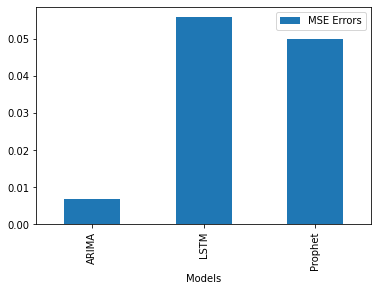

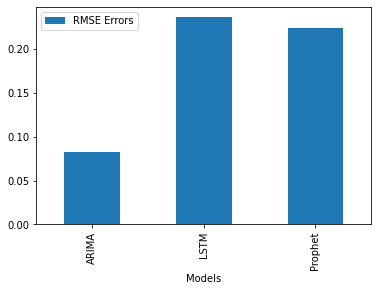

In [72]:
print(f"Mean: {test_df['Value'].mean()}")
errors
errors.plot(kind="bar",x="Models",y="MSE Errors")
errors.plot(kind="bar",x="Models",y="RMSE Errors")

In [73]:
errors["Country"]=country_to_predict
errors

,Models,RMSE Errors,MSE Errors,Country
0,ARIMA,0.083181,0.006919,Libya
1,LSTM,0.236363,0.055867,Libya
2,Prophet,0.223743,0.050061,Libya


In [74]:
import pandas
from openpyxl import load_workbook

book = load_workbook('errors.xlsx')
writer = pandas.ExcelWriter('errors.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    errors.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index =False,header= False)

writer.save()

In [75]:
output3=test_df
output3["Country"]=country_to_predict
output3.reset_index()
output3.index=['2013', '2014', '2015','2016', '2017', '2018']
output3

,Value,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions,Country
2013,71.907,71.902947,71.961344,72.246216,Libya
2014,71.981,71.969526,72.022162,72.263836,Libya
2015,72.121,72.092529,72.083529,72.306681,Libya
2016,72.311,72.251227,72.145523,72.376166,Libya
2017,72.520,72.417461,72.208223,72.456333,Libya
2018,72.724,72.561308,72.271711,72.473953,Libya


In [76]:
import pandas
from openpyxl import load_workbook

book = load_workbook('comparison.xlsx')
writer = pandas.ExcelWriter('comparison.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    output3.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index =True,header= False)

writer.save()

<Figure size 1368x648 with 0 Axes>

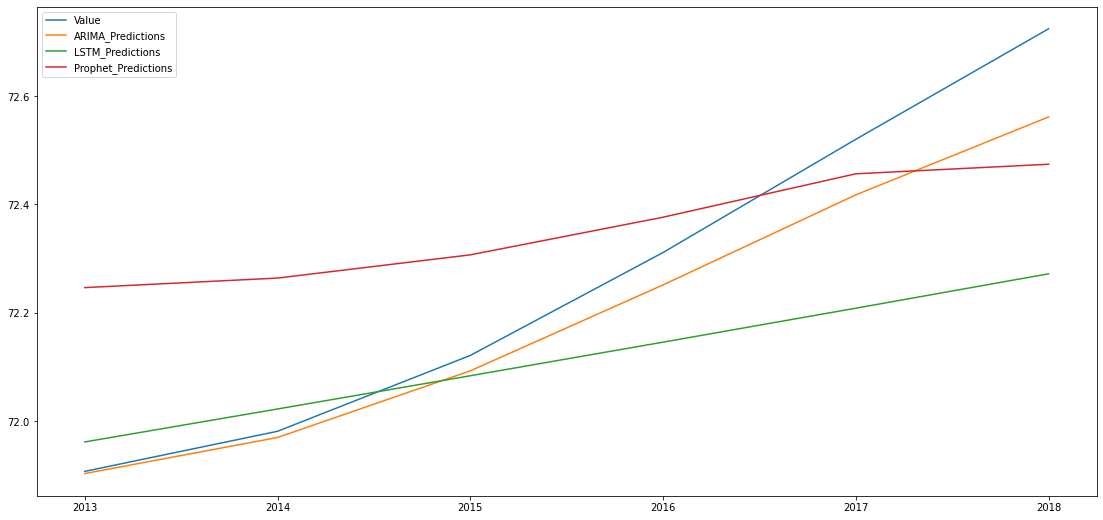

In [77]:
plt.figure(figsize=(19,9))
test_df.plot(figsize=(19,9))